In [1]:
import zipfile

import numpy as np
import os
import cv2

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
with zipfile.ZipFile("./IDENTIFICACION.zip","r") as zip_ref:
    zip_ref.extractall("OCR")

# Cargar datos

In [19]:
# !/usr/bin/python
train_path = "./OCR/ORLProcessed/Train"
test_path = "./OCR/ORLProcessed/Test"


X = []
X_labels = []
Y = []
Y_labels = []
for root, dirs, files in os.walk(train_path, topdown=False):
   for name in files:
     filepath = os.path.join(root, name)
     im = cv2.imread(filepath,-1)
     im_vector = im.flatten()
     X.append(im_vector)
     label = root.split("/")[-1]
     X_labels.append(label)

for root, dirs, files in os.walk(test_path, topdown=False):
  for name in files:
    filepath = os.path.join(root, name)
    im = cv2.imread(filepath,-1)
    im_vector = im.flatten()
    Y.append(im_vector)
    label = root.split("/")[-1]
    Y_labels.append(label)

X = np.transpose(np.matrix(X))
Y = np.transpose(np.matrix(Y))

# PCA

Trying different dimensions...Progress:: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]

Best accuracy: 0.905, Dimensions projected: 153




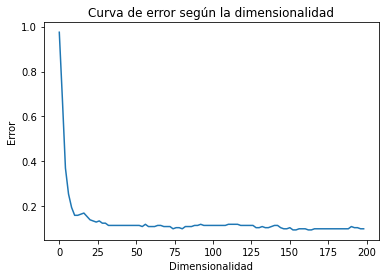

In [20]:
##### PCA COMPUTATIONS #####
avg_image_vector = np.mean(X, axis=1)
A = X - avg_image_vector

C = 1/X.shape[0] * np.matmul(np.transpose(A), A)

delta_prime, B_prime = np.linalg.eig(C)

delta = (X.shape[0]/X.shape[1]) * delta_prime

B = A*B_prime
B = B/np.linalg.norm(B, axis=0)

##### ACCURACY AND ERROR FOR DIFFERENT PROJECTED DIMENSIONS #####
best_accuracy=-np.inf
dimension=-1
values = []
dimensions = []

for d in tqdm(np.arange(0,199,2), desc = 'Trying different dimensions...Progress:'):
  mat_projection = B[:,:d]
  mat_projection_transp = np.transpose(mat_projection)
  X_projected = mat_projection_transp * X
  Y_projected = mat_projection_transp * Y
  predicted_person = []
  for i in range(Y.shape[1]):
    min_dist=np.inf
    label_idx = -1
    for j in range(X_projected.shape[1]):
      actual_dist = np.linalg.norm(Y_projected[:,i] - X_projected[:,j])
      if actual_dist < min_dist:
        label_idx = j
        min_dist = actual_dist
    predicted_person.append(X_labels[label_idx])

  total = 0
  accuracy = 0

  for i in range(len(predicted_person)):
    if predicted_person[i] == Y_labels[i]:
      accuracy+=1
    total+=1
  total_accuracy = accuracy/total
  values.append(1-total_accuracy)
  dimensions.append(d)
  if(total_accuracy > best_accuracy):
    best_accuracy = total_accuracy
    dimension = d
print("Best accuracy: %.3f, Dimensions projected: %d" % (best_accuracy, dimension+1))
print("\n")

##### PLOTTING RESULTS #####
plt.plot(dimensions, values)
plt.title("Curva de error según la dimensionalidad")
plt.xlabel("Dimensionalidad")
plt.ylabel("Error")
plt.show()

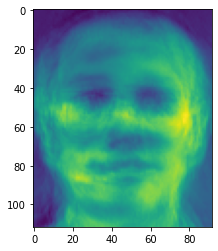

In [7]:
from matplotlib import pyplot as plt
plt.imshow(np.reshape(mat_projection[:,2],(112,92)))

# LDA partiendo de una proyección previa de PCA

Trying different dimensions...Progress:: 100%|██████████| 4/4 [02:11<00:00, 32.99s/it]


Best accuracy: 0.920, Dimensions projected: 37, PCA: 200




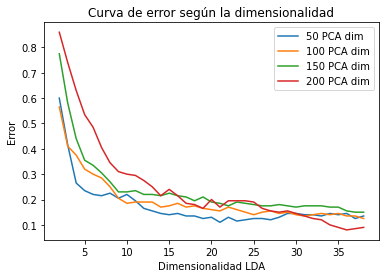

In [21]:
best_accuracy = -np.inf
dimension = -1
pca = -1
plot = {}

for pca_dim in tqdm([50, 100, 150, 200], desc = 'Trying different dimensions...Progress:'):
  plot[pca_dim] = {"error":[], "dimensions":[]}

  ##### Initially projecting data to PCA #####
  mat_projection = B[:,:pca_dim]
  mat_projection_transp = np.transpose(mat_projection)
  X_projected = mat_projection_transp * X
  Y_projected =  mat_projection_transp * Y

  ##### Compute LDA #####
  features, samples = X_projected.shape
  global_mean = np.average(X_projected, axis=1)

  mean_per_class = {}
  for i in range(samples):
    target_class = X_labels[i]
    if target_class in mean_per_class:
      mean, samples_per_class = mean_per_class[target_class]
    else:
      mean, samples_per_class = (np.zeros(shape=(features, 1)), 0)
    mean += X_projected[:, i]
    samples_per_class += 1
    mean_per_class[target_class] = (mean, samples_per_class)

  for target_class in mean_per_class.keys():
    mean, samples_per_class = mean_per_class[target_class]
    mean_per_class[target_class] = (mean/samples_per_class, samples_per_class)

  Sb = np.zeros(shape=(features, features))
  for target_class in mean_per_class.keys():
    mean_of_class = mean_per_class[target_class][0]
    samples_per_class = mean_per_class[target_class][1]
    aux_matrix = (mean_of_class - global_mean) * np.transpose(mean_of_class - global_mean)
    aux_matrix *= samples_per_class
    Sb += aux_matrix

  Sw = np.zeros(shape=(features, features))
  for i in range(samples):
    target_class = X_labels[i]
    sample = X_projected[:, i]
    uc = mean_per_class[target_class][0]
    Sw += (sample - uc) * np.transpose(sample - uc)

  from scipy.linalg import eig
  eigvals, eigenvectors = eig(Sb, Sw)

  ##### ACCURACY AND ERROR FOR DIFFERENT PROJECTED DIMENSIONS OF LDA #####
  num_clases = len(mean_per_class.keys())

  for d in np.arange(2, num_clases-1, 1, dtype=int):
    if d < pca_dim:
      proj_matrix = eigenvectors[:,:d]
      mat_projection_transp = np.transpose(proj_matrix)
      X_projected_lda = mat_projection_transp * X_projected

      Y_projected_lda = mat_projection_transp * Y_projected
      predicted_person = []
      for i in range(Y_projected_lda.shape[1]):
        min_dist=np.inf
        label_idx = -1
        for j in range(X_projected_lda.shape[1]):
          actual_dist = np.linalg.norm(Y_projected_lda[:,i] - X_projected_lda[:,j])
          if actual_dist < min_dist:
            label_idx = j
            min_dist = actual_dist
        predicted_person.append(X_labels[label_idx])

      total = 0
      accuracy = 0

      for i in range(len(predicted_person)):
        if predicted_person[i] == Y_labels[i]:
          accuracy+=1
        total+=1
      total_accuracy = accuracy/total
      plot[pca_dim]["dimensions"].append(d)
      plot[pca_dim]["error"].append(1-total_accuracy)

      if(total_accuracy > best_accuracy):
        best_accuracy = total_accuracy
        dimension = d
        pca = pca_dim
print("Best accuracy: %.3f, Dimensions projected: %d, PCA: %d" % (best_accuracy, dimension+1, pca))
print("\n")

##### PLOTTING RESULTS #####
for i in plot.keys():
  plt.plot(plot[i]["dimensions"], plot[i]["error"], label=str(i) + " PCA dim")
plt.legend()
plt.title("Curva de error según la dimensionalidad")
plt.xlabel("Dimensionalidad LDA")
plt.ylabel("Error")
plt.show()